In [ ]:
# this will work if the notebook is launched from the GpABC.jl checkout dir, and 
# environment variable JULIA_PROJECT=@.

using GpABC, OrdinaryDiffEq, Distances, Plots, Distributions, LinearAlgebra

# Performing the Linear Noise Approximation and conducting ABC

This notebook will guide the user through performing the linear noise approximation (LNA) on any system the user wishes, and on using the LNA when conducting ABC for parameter estimation.


## Stochastic Three Gene Toy Example

The Three Gene Example is taken from Guy Karlebach and Ron Shamir "Modelling and analysis of gene regulatory networks" $\textit{Nature Reviews Molecular Cell Biology}$ (2008).

Consider a Three Gene Example where Gene 1, 2 and 3 are represented by $g_1$, $g_2$ and $g_3$ respectively and $\textbf{g} = (g_1, g_2, g_3)^T$. The kinetic parameters of the system are represented through $k_*$. In this system the concentrations of these genes vary and depend on each other, in a way that is determined by the equations below: 

$$
\begin{align*} 
\emptyset & \overset{\hphantom{k_{1}} \, k_{1,s} \, g_3 \hphantom{k}}{\longrightarrow}   g_1  \\ 
g_1 & \overset{\hphantom{k_{1,s}} \, k_{1,d} \,  \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 & \overset{ \hphantom{k_{1}} \,k_{2,s} \, g_1 \hphantom{k_{1,s}}}{\longrightarrow} g_1 + g_2 \\ 
g_2 & \overset{\hphantom{k_{1,s}}\, k_{2,d} \, \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 + g_2 & \overset{k_{3,s} \, k_{3,1} \, k_{3,2} }{\longrightarrow} g_1 + g_2 + g_3 \\ 
g_3 & \overset{ \hphantom{k_{1,s}} \, k_{3,d} \, \hphantom{k_{1,s}}}{\longrightarrow}  \emptyset 
\end{align*}
$$

These equations are visualised in the below diagram, adapted from Guy Karlebach and Ron Shamir "Modelling and analysis of gene regulatory networks" $\textit{Nature Reviews Molecular Cell Biology}$ (2008). 

<img src="threegeneinteractions.png" width="500" height="1000">

The interactions between the genes can be seen: Gene 1 activates Gene 2 and Gene 3, Gene 2 activates Gene 3 and finally Gene 3 represses Gene 1.  

What cannot be seen in the diagram is the degradation of all the genes and the activation of Gene 1 from a constant source. 

The reaction rates of this model are: 

 $\textbf{f}= \begin{bmatrix}
      \frac{ k_{1,s}}{1+k_{1,3} \, \textbf{g}_3}, & k_{1,d} \, \textbf{g}_1, & \frac{k_{2,s} \, k_{2,1}\, \textbf{g}_1}{1+k_{2,1} \, \textbf{g}_1}, & k_{2,d} \, \textbf{g}_2, & \frac{k_{3,s} \, k_{3,1} \, \textbf{g}_1 \,  k_{3,2} \, \textbf{g}_2}{(1+k_{3,1} \, \textbf{g}_1)(1+k_{3,2} \, \textbf{g}_2)}, & k_{3,d} \, \textbf{g}_3        
     \end{bmatrix} ^T$. 


The Stoichiometry matrix of the system is:

$$\mathcal{S} =
 \begin{pmatrix}
  1 & -1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & -1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & -1  
 \end{pmatrix} $$ 
     
The user requires $\mathcal{S}$ and $\textbf{f}$ when constructing a stochastic model of a system.

In this example, the parameters $[k_{1,s}, k_{2,s}, k_{3,s}, k_{1,d}, k_{1,d}, k_{2,d}, k_{3,d}, k_{1,3}, k_{2,1}, k_{3,1}, k_{3,1}]$ have been chosen to take values $[2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]$ 

So let's contruct $\mathcal{S}$ and $\textbf{f}$:

In [2]:
S = [1.0 -1.0 0.0 0.0 0.0 0.0;  # stoichometry matrix 
     0.0 0.0 1.0 -1.0 0.0 0.0;
     0.0 0.0 0.0 0.0 1.0 -1.0]

params = [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0] #parameters of the model

reaction_rate_function = function(x,params)   # reaction rates of model
    f = [params[1]/(1+params[7]*x[3]),
        params[4]*x[1],
        params[2]*params[8]*x[1]/(1+params[8]*x[1]),
        params[5]*x[2],
        params[3]*params[9]*x[1]*params[10]*x[2]/(1+params[9]*x[1])/(1+params[10]*x[2]),
        params[6]*x[3]]
    return f
end

#3 (generic function with 1 method)

The reaction rates must be stated in a function.

An Ordinary Differential Equation (ODE) model is given by the relationship $\dot{\textbf{g}} = \mathcal{S} \, \textbf{f} $.

An example of this can be seen below. Notice how in `GeneReg` the only thing defining the ODE is:

$\mathcal{S} \, \textbf{f}$ .

The initial conditions, timspan, solver and saveat are arbitrary.

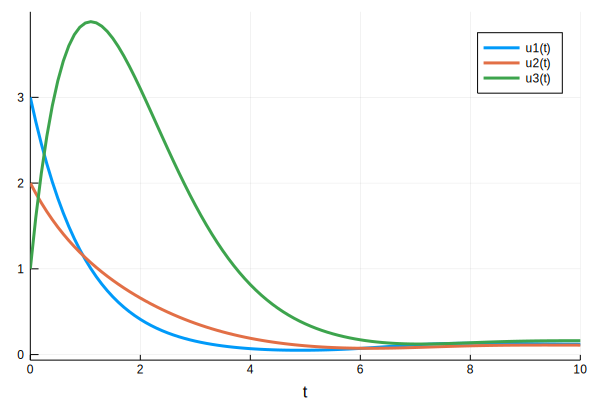

In [3]:
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

Tspan = (0., 10.) #timspan
x0 = [3.0, 2.0, 1.0] #initial conditions
solver = RK4()
saveat = 0.1

ODE_solution = GeneReg(params, Tspan, x0, solver, saveat)

plot(ODE_solution)

## Stochastic Example

Before calculating the LNA, the stochastic simulation of `GeneReg` is shown:

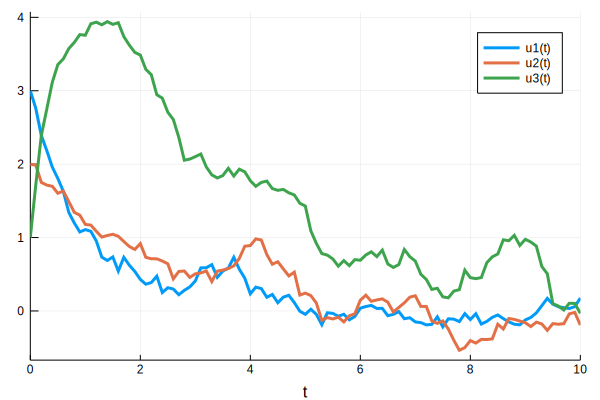

In [4]:
StochGeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::StochasticDiffEq.StochasticDiffEqAlgorithm, dt::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end
    
  function sigma_3GeneReg(dx, x, par, t)  #adding some noise to the model
    dx[1] = 0.3
    dx[2] = 0.3
    dx[3] = 0.3
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = SDEProblem(ODE_3GeneReg, sigma_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, dt=dt)

  return Obs
end

solver = EM()  
dt = 0.1

SDE_solution = StochGeneReg(params, Tspan, x0, solver, saveat)

plot(SDE_solution)

## Computing the LNA

Now, if the user wishes to do the LNA of the above stochastic problem, the process begins by setting up an LNAInput structure:

In [5]:
volume = 100.0
input = LNAInput(params, S, reaction_rate_function, volume);

The LNA is the solution to the two ODEs, where $\Omega$ is the volume:
    
$$
\begin{align}
\frac{d\varphi}{dt}&=\mathcal{S}\textbf{f}(\boldsymbol\varphi) \label{mean} \\ 
\frac{d\Sigma}{dt}&=\mathcal{A} \, \Sigma + \Sigma \, \mathcal{A}^T + \frac{1}{\sqrt{\Omega}} \, \mathcal{S} \, \text{diag}(\textbf{f}(\boldsymbol\varphi)) \, \mathcal{S}^T \label{covar}
\end{align}
$$

If the user wishes to see the results from the two ODEs the user must provide the initial condtions of the ODEs in the form of (initial conditions of the species, initial covariance) and then call `compute_LNA`. 

This returns a `LNA` structure which holds the solutions to the above ODEs. The means, $\varphi$ can be called by `lna.traj_means` and the covariance $\Sigma$ can be called by `lna.traj_covars`. The time points the system of ODEs were solved for can be called by `lna.time_points`. 

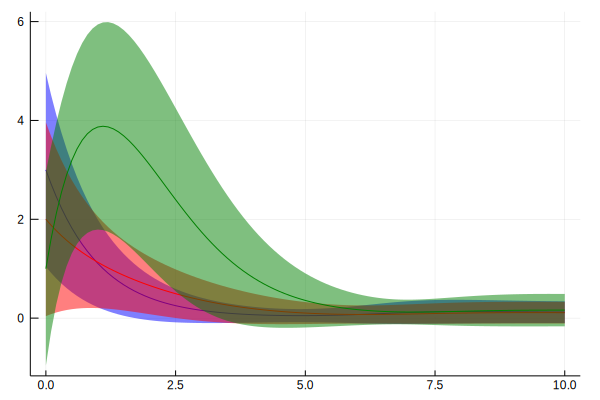

In [15]:
x0 = ([3.0, 2.0, 1.0], Matrix(1.0I, 3,3)) #initial conditions
solver = RK4()
saveat = 0.1

lna = compute_LNA(input, x0, Tspan, saveat)
t = lna.time_points
variance = zeros(size(S)[1], length(t))
for (idx, elt) in enumerate(lna.traj_covars)
    variance[:, idx] = diag(elt)
end

plot(t, lna.traj_means[1,:], ribbon=1.96*sqrt.(variance[1,:]), c=:blue, leg=false)
plot!(t, lna.traj_means[2,:], ribbon=1.96*sqrt.(variance[2,:]), c=:red, leg=false)
plot!(t, lna.traj_means[3,:], ribbon=1.96*sqrt.(variance[3,:]), c=:green, leg=false)

The three means are plotted with the shaded areas being the 95% confidence intervals.

## Sampling from the LNA

The LNA gives the mean of the trajectories and the covariance between them; hence a single trajectory can be sampled from a Multivariate Normal distribution. The function `sample_LNA_trajectories` automatically does this. 

The user can also sample more than one trajectory, which are then averaged, by changing `n_samples`. The larger the number of samples that are averaged over, the less noisy the outputs are. The effect of varying `n_samples` is shown below:

  0.001508 seconds (2.04 k allocations: 97.844 KiB)


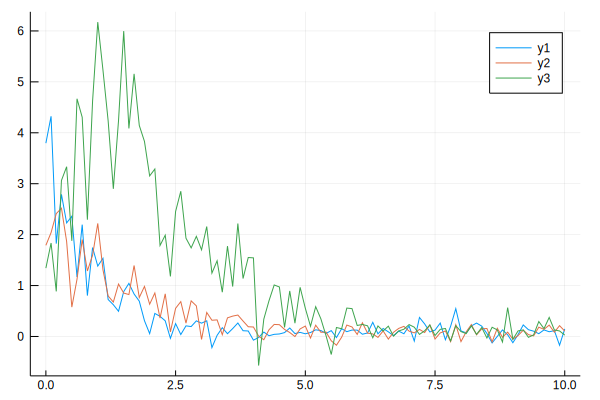

In [16]:
n_samples = 1

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000773 seconds (2.04 k allocations: 119.938 KiB)


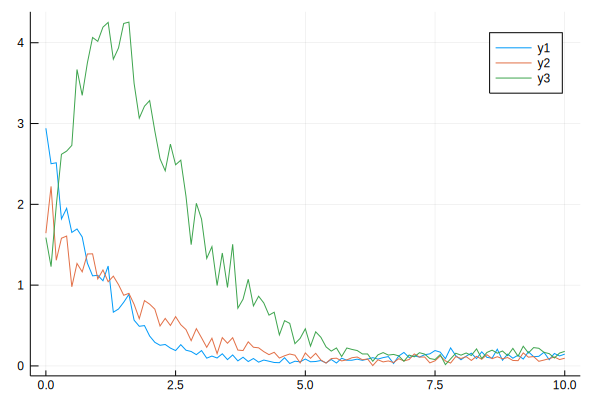

In [17]:
n_samples = 10

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.001213 seconds (2.04 k allocations: 339.297 KiB)


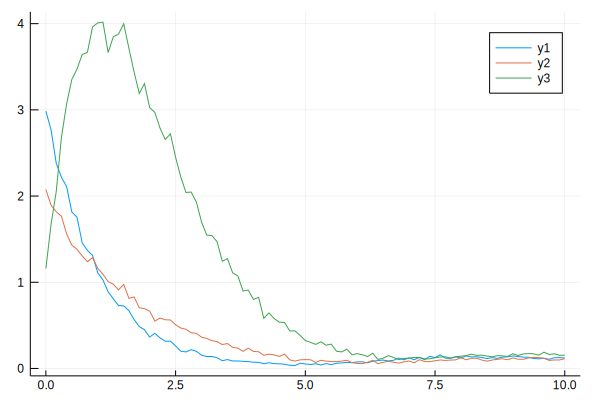

In [18]:
n_samples = 100

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

## ABC using the LNA

The same examples located in `abc-examples.ipynb` are shown but using the LNA. Let's try and estimate the first three parameters, comparing simulation based ABC and emulation based ABC.

### Simulation-Based Rejection ABC

In [10]:
function simulator_function(var_params)
    input = LNAInput(vcat(var_params, params[n_var_params+1:end]), S, reaction_rate_function, volume)
    return get_LNA_trajectories(input, n_samples, x0, Tspan, saveat)
end

simulator_function (generic function with 1 method)

┌ Warning: Simulation reached maximum iterations 5000 before finding 500 particles - will return 296
└ @ GpABC /Users/tanhevg/Desktop/projects/gaussian_processes/GpABC.jl/src/abc/rejection.jl:92


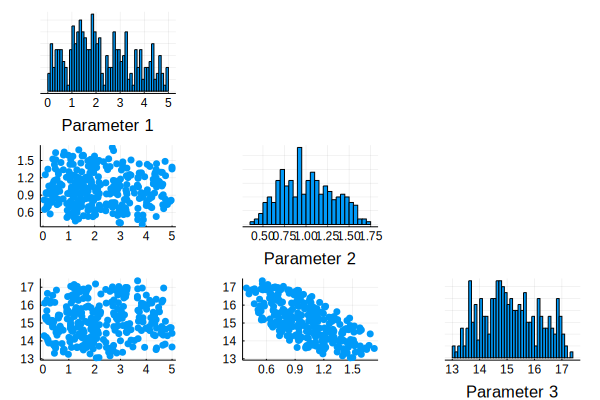

In [11]:
priors = [Uniform(0., 5.), Uniform(0., 5.), Uniform(10., 20.)]
n_var_params = length(priors)
n_particles = 500
threshold = 2.0
progress_every = 100
reference_data = lna_trajectories

sim_result = SimulatedABCRejection(reference_data,
                        simulator_function,
                        priors,
                        threshold,
                        n_particles;
                        write_progress = false
                        )

plot(sim_result)

### Emulation-Based Rejection ABC

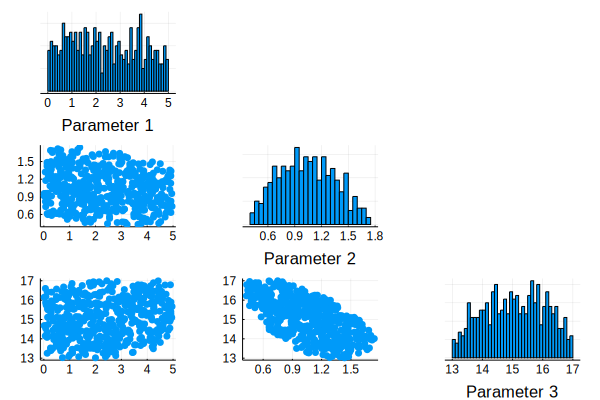

In [12]:
n_design_points = 200

emu_result = EmulatedABCRejection(reference_data,
                        simulator_function,
                        priors,
                        threshold,
                        n_particles,
                        n_design_points;
                        write_progress = false)


plot(emu_result)

### Simulation-Based ABC-SMC

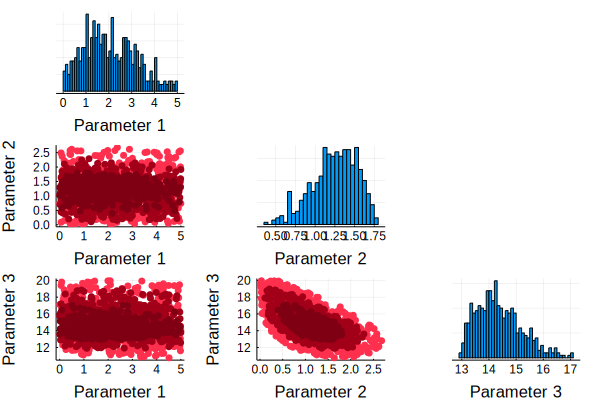

In [13]:
threshold_schedule = [4.0, 3.0, 2.0]

sim_abcsmc_res = SimulatedABCSMC(reference_data,
                        simulator_function,
                        priors,
                        threshold_schedule,
                        n_particles;
                        write_progress = false)
population_colors=["#FF2F4E", "#A20018", "#800013"]
plot(sim_abcsmc_res, population_colors=population_colors)

### Emulation-Based ABC-SMC

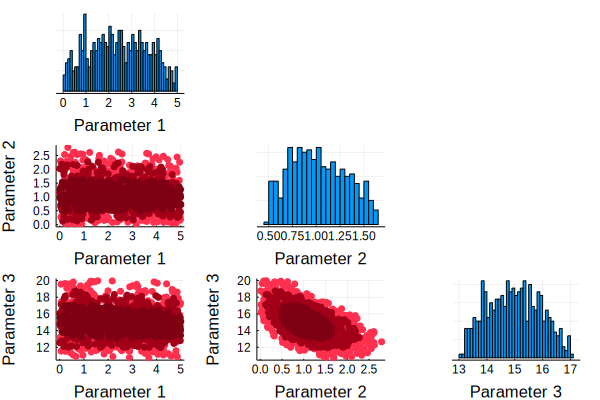

In [14]:

emu_abcsmc_res = EmulatedABCSMC(reference_data,
                        simulator_function,
                        priors,
                        threshold_schedule,
                        n_particles,
                        n_design_points;
                        write_progress = false)

plot(emu_abcsmc_res, population_colors=population_colors)